In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
import missingno as msno
sns.set_style("darkgrid")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
#Importing the data
df=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
df.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


# EDA

In [4]:
df.shape

(42, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [7]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [8]:
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [9]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [10]:
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [11]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))

In [12]:
df=df.drop("Quarter",axis=1)
df.head()

,Sales,Quarter_Year
0,1734.827000,Q1 1986
1,2244.960999,Q2 1986
2,2533.804993,Q3 1986
3,2154.962997,Q4 1986
4,1547.818996,Q1 1987


In [13]:
df[['Quarters', 'Year']] = df['Quarter_Year'].str.split(' ', n=1, expand=True)
df.head()

,Sales,Quarter_Year,Quarters,Year
0,1734.827000,Q1 1986,Q1,1986
1,2244.960999,Q2 1986,Q2,1986
2,2533.804993,Q3 1986,Q3,1986
3,2154.962997,Q4 1986,Q4,1986
4,1547.818996,Q1 1987,Q1,1987


In [14]:
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

,Sales,Quarter_Year,Quarters,Year,Date
0,1734.827000,Q1 1986,Q1,1986,1986-01-01
1,2244.960999,Q2 1986,Q2,1986,1986-04-01
2,2533.804993,Q3 1986,Q3,1986,1986-07-01
3,2154.962997,Q4 1986,Q4,1986,1986-10-01
4,1547.818996,Q1 1987,Q1,1987,1987-01-01
5,2104.411995,Q2 1987,Q2,1987,1987-04-01
6,2014.362999,Q3 1987,Q3,1987,1987-07-01
7,1991.746998,Q4 1987,Q4,1987,1987-10-01
8,1869.049999,Q1 1988,Q1,1988,1988-01-01
9,2313.631996,Q2 1988,Q2,1988,1988-04-01


In [15]:
df1=df.drop("Quarter_Year",axis=1)


In [16]:
df1.head(4)

,Sales,Quarters,Year,Date
0,1734.827000,Q1,1986,1986-01-01
1,2244.960999,Q2,1986,1986-04-01
2,2533.804993,Q3,1986,1986-07-01
3,2154.962997,Q4,1986,1986-10-01


In [17]:
df1=df1.drop("Year",axis=1)

In [18]:
df1.head(3)

,Sales,Quarters,Date
0,1734.827000,Q1,1986-01-01
1,2244.960999,Q2,1986-04-01
2,2533.804993,Q3,1986-07-01


In [19]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [20]:
df1.head()

,Sales,Quarters
Date,,
1986-01-01,1734.827000,Q1
1986-04-01,2244.960999,Q2
1986-07-01,2533.804993,Q3
1986-10-01,2154.962997,Q4
1987-01-01,1547.818996,Q1


# CREATE DUMMIES FOR QUARTER

In [21]:
df1.head()

,Sales,Quarters
Date,,
1986-01-01,1734.827000,Q1
1986-04-01,2244.960999,Q2
1986-07-01,2533.804993,Q3
1986-10-01,2154.962997,Q4
1987-01-01,1547.818996,Q1


In [22]:
dummy = pd.DataFrame(pd.get_dummies(df1['Quarters']))
df1 = pd.concat((df1, dummy), axis=1)

df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [23]:
df1=df1.drop("Quarters",axis=1)
df1.head()

,Sales,Q1,Q2,Q3,Q4
Date,,,,,
1986-01-01,1734.827000,1,0,0,0
1986-04-01,2244.960999,0,1,0,0
1986-07-01,2533.804993,0,0,1,0
1986-10-01,2154.962997,0,0,0,1
1987-01-01,1547.818996,1,0,0,0


In [24]:
df1.describe()

,Sales,Q1,Q2,Q3,Q4
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,2994.353308,0.261905,0.261905,0.238095,0.238095
std,977.930896,0.445001,0.445001,0.431081,0.431081
min,1547.818996,0.000000,0.000000,0.000000,0.000000
25%,2159.714247,0.000000,0.000000,0.000000,0.000000
50%,2782.376999,0.000000,0.000000,0.000000,0.000000
75%,3609.250000,0.750000,0.750000,0.000000,0.000000
max,5253.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
sales = df1.iloc[:, 0]


In [26]:
sales

Date
1986-01-01    1734.827000
1986-04-01    2244.960999
1986-07-01    2533.804993
1986-10-01    2154.962997
1987-01-01    1547.818996
1987-04-01    2104.411995
1987-07-01    2014.362999
1987-10-01    1991.746998
1988-01-01    1869.049999
1988-04-01    2313.631996
1988-07-01    2128.320000
1988-10-01    2026.828999
1989-01-01    1910.603996
1989-04-01    2331.164993
1989-07-01    2206.549995
1989-10-01    2173.967995
1990-01-01    2148.278000
1990-04-01    2739.307999
1990-07-01    2792.753998
1990-10-01    2556.009995
1991-01-01    2480.973999
1991-04-01    3039.522995
1991-07-01    3172.115997
1991-10-01    2879.000999
1992-01-01    2772.000000
1992-04-01    3550.000000
1992-07-01    3508.000000
1992-10-01    3243.859993
1993-01-01    3056.000000
1993-04-01    3899.000000
1993-07-01    3629.000000
1993-10-01    3373.000000
1994-01-01    3352.000000
1994-04-01    4342.000000
1994-07-01    4461.000000
1994-10-01    4017.000000
1995-01-01    3854.000000
1995-04-01    4936.000000
1995-07

# DATA VISUALTISATIONS 

<Axes: xlabel='Sales', ylabel='Density'>

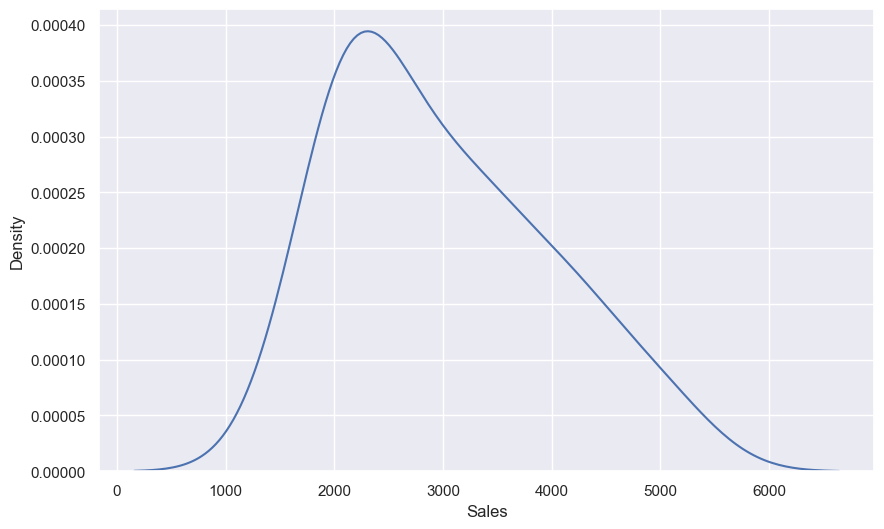

In [27]:
sns.kdeplot(df.Sales)

<Axes: xlabel='Date', ylabel='Sales'>

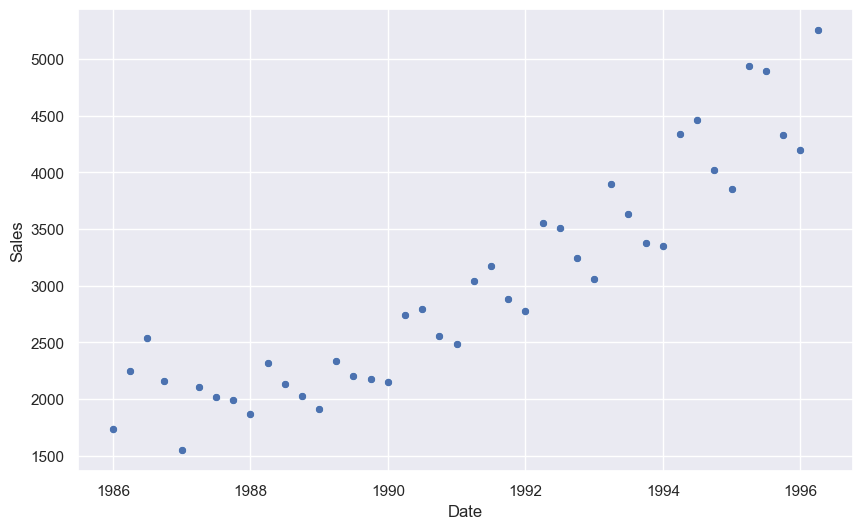

In [28]:
sns.scatterplot(df1.Sales)

<Axes: >

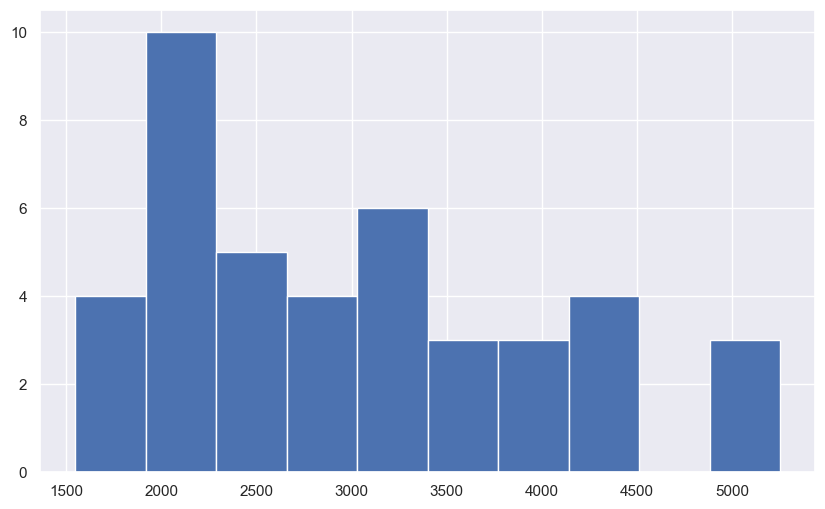

In [29]:
df1.Sales.hist()


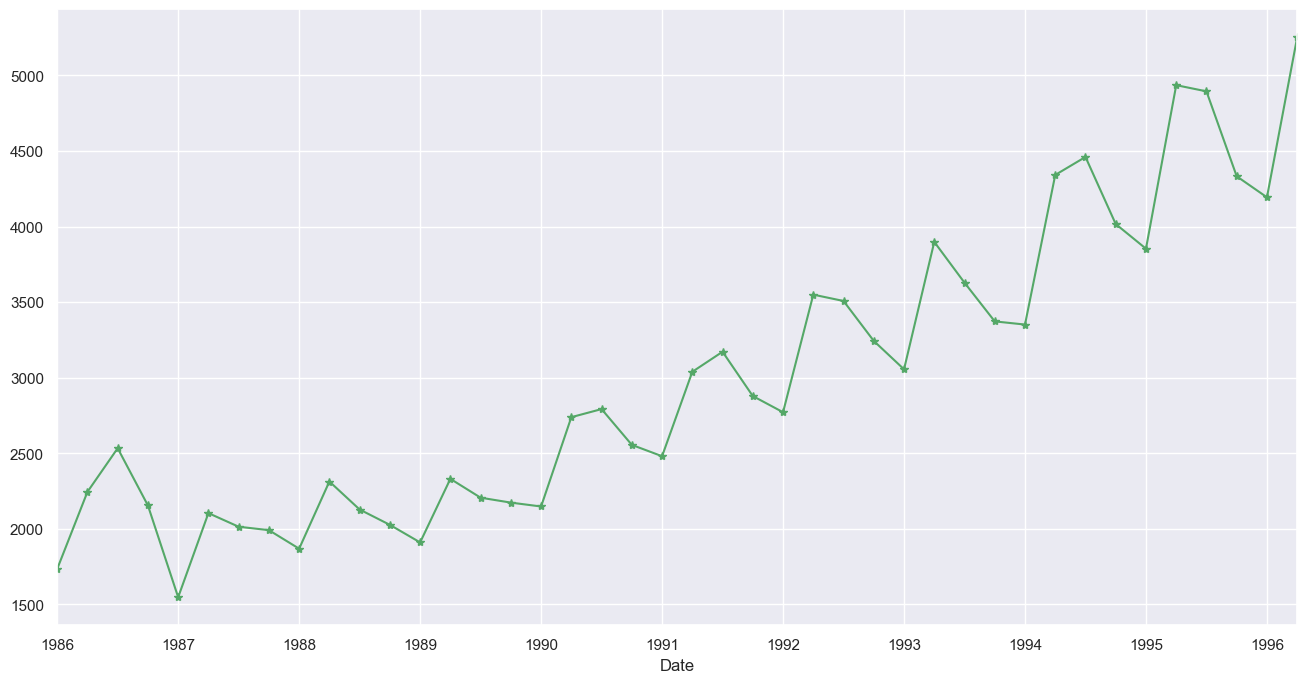

In [30]:
df1['Sales'].plot(figsize=(16, 8),color='g',marker='*')
plt.show()

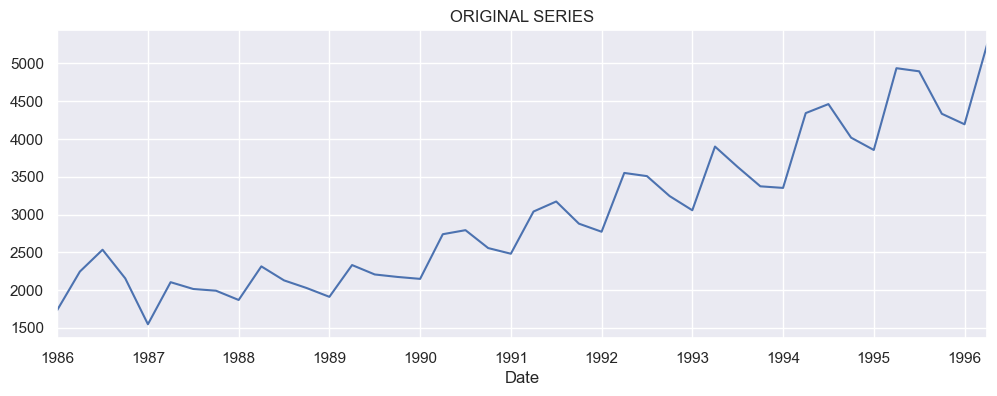

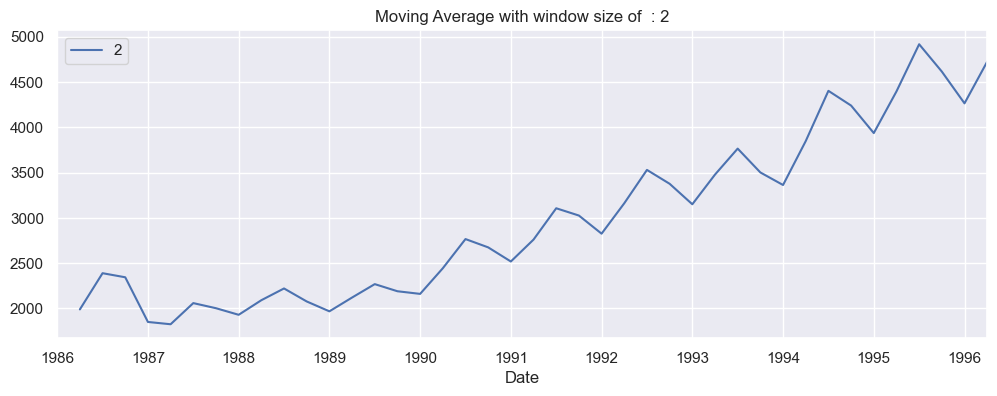

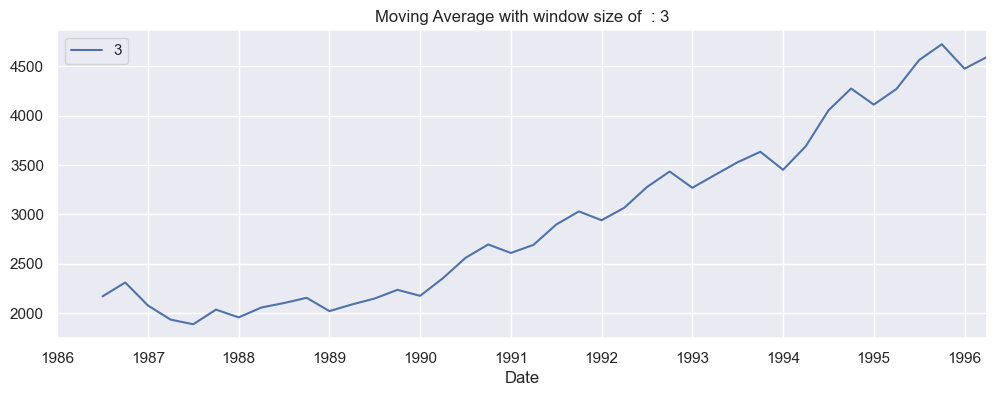

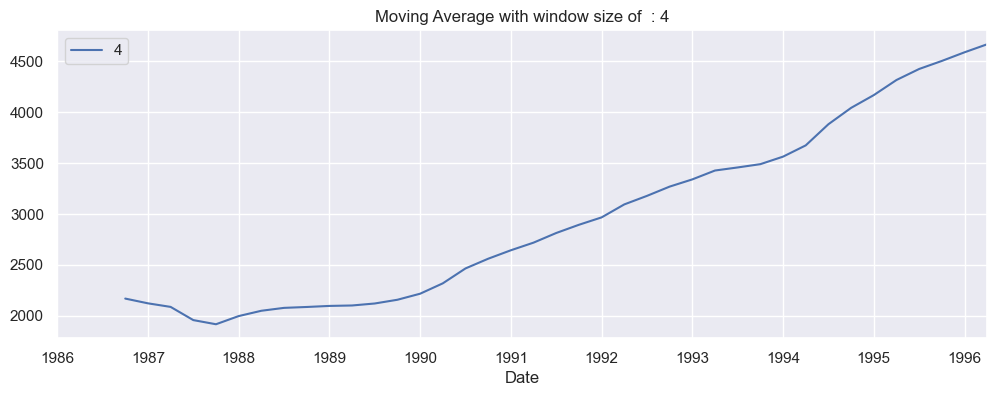

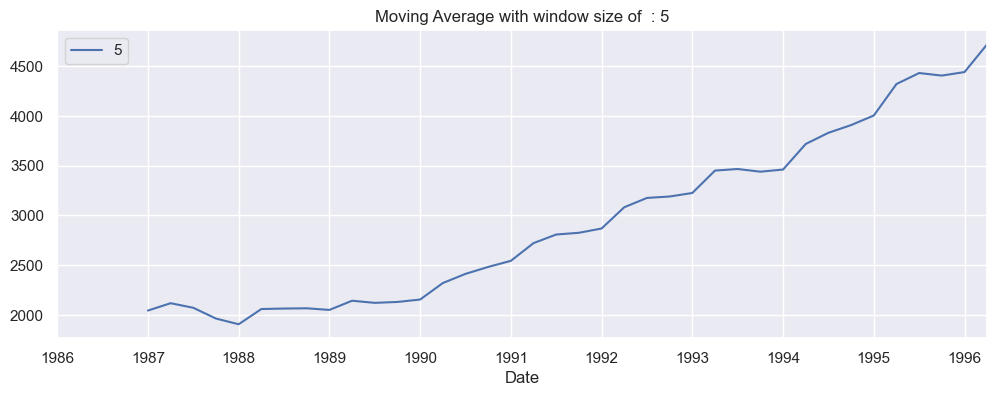

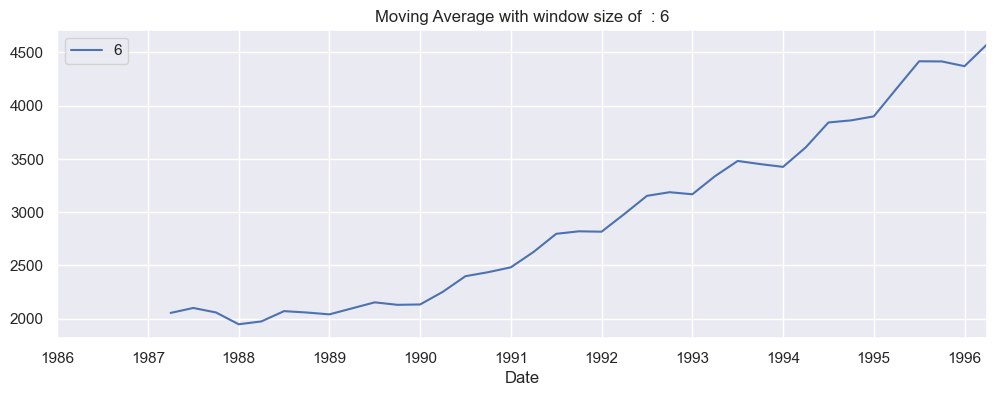

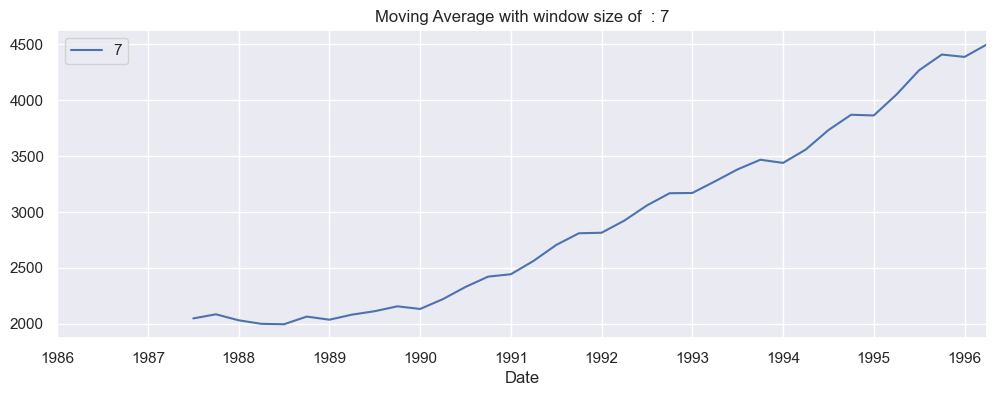

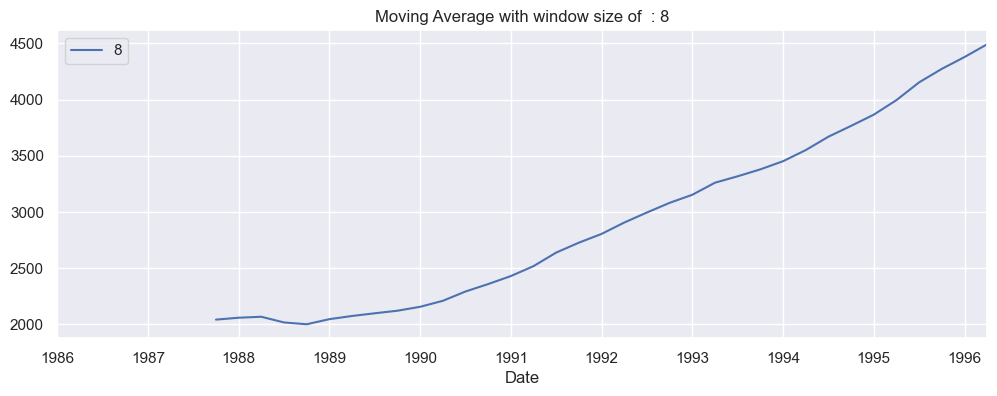

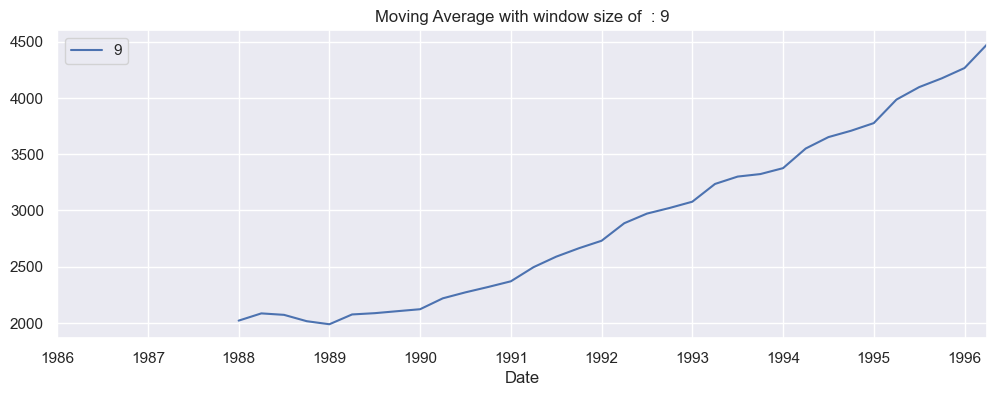

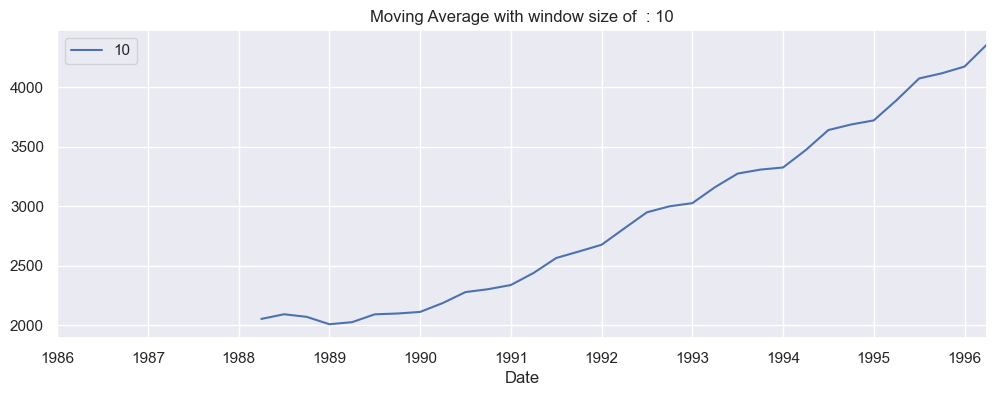

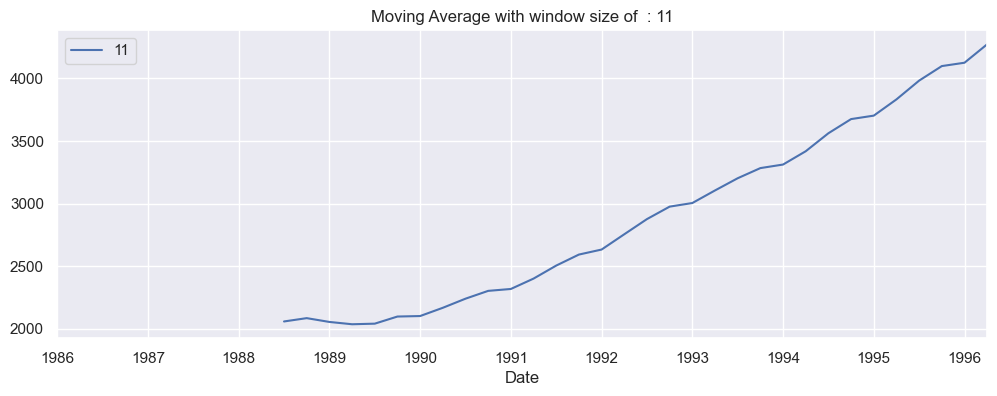

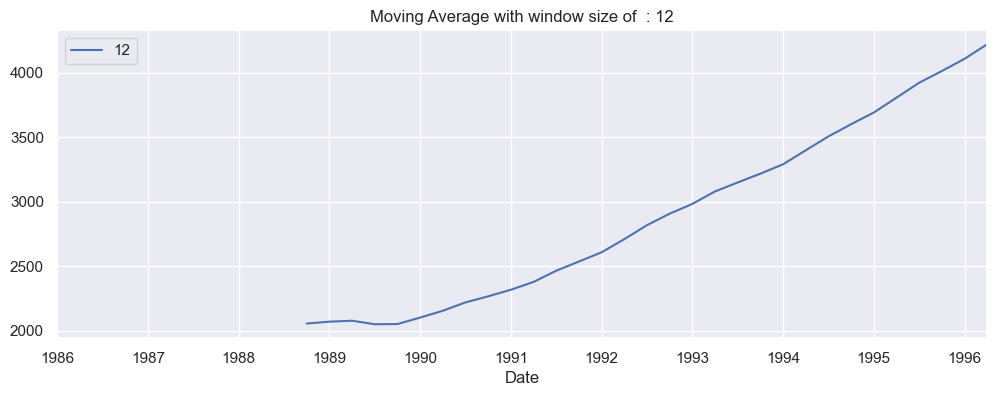

In [31]:
plt.figure(figsize=(12,4))
df1.Sales.plot(label="org")
plt.title("ORIGINAL SERIES")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    df1.Sales.rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average with window size of  : "+str(i))
    plt. legend(loc='best')
    plt.show()


# Time series decomposition plot

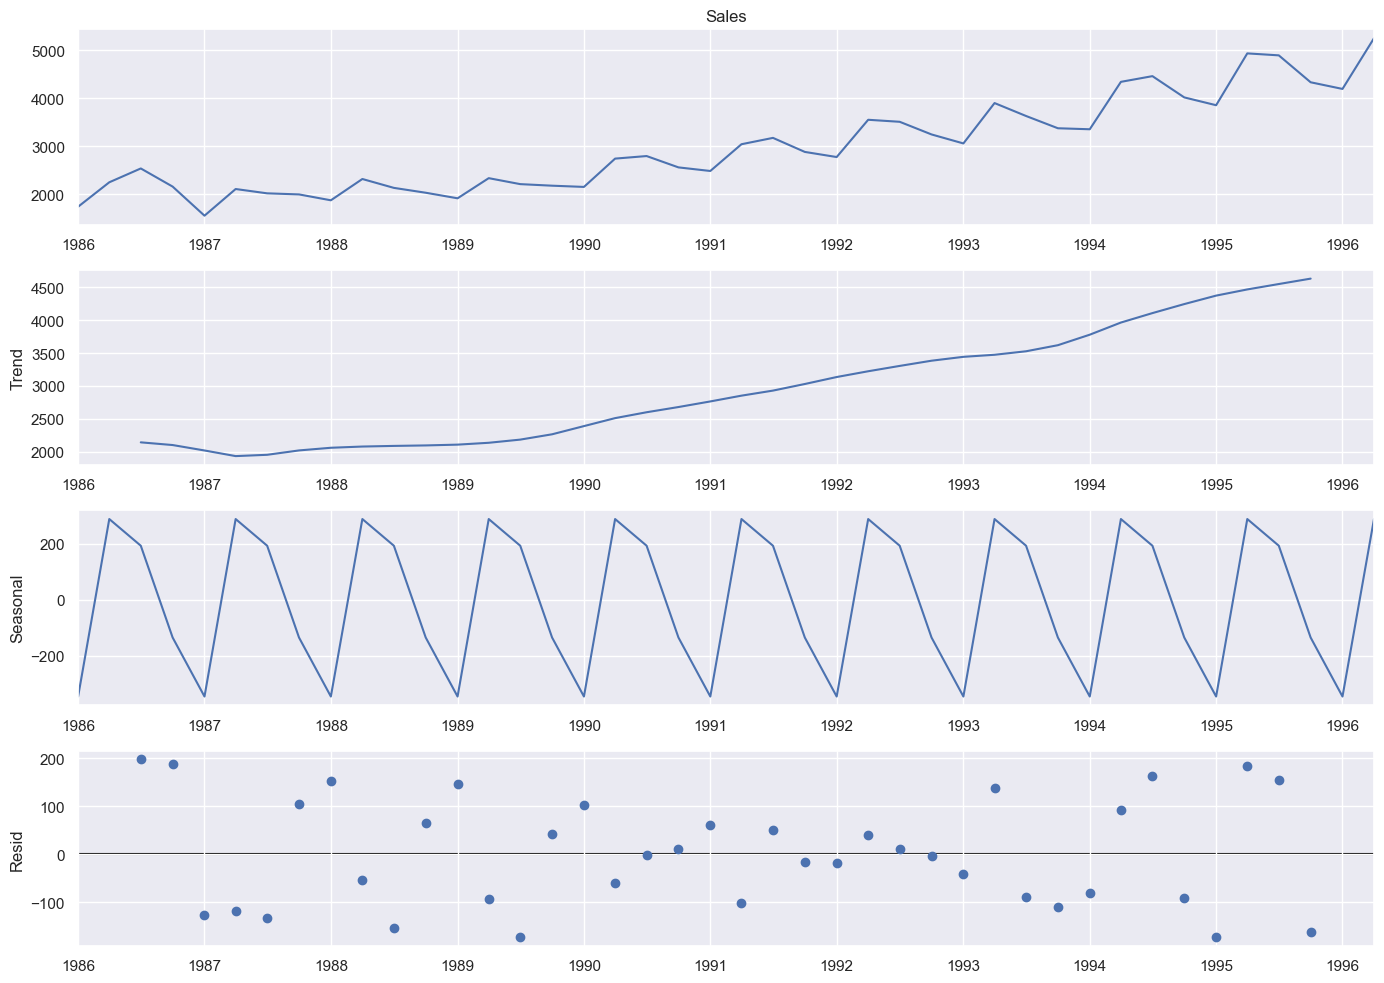

In [32]:
decompose_ts_add = seasonal_decompose(sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

<Axes: xlabel='Quarters', ylabel='Sales'>

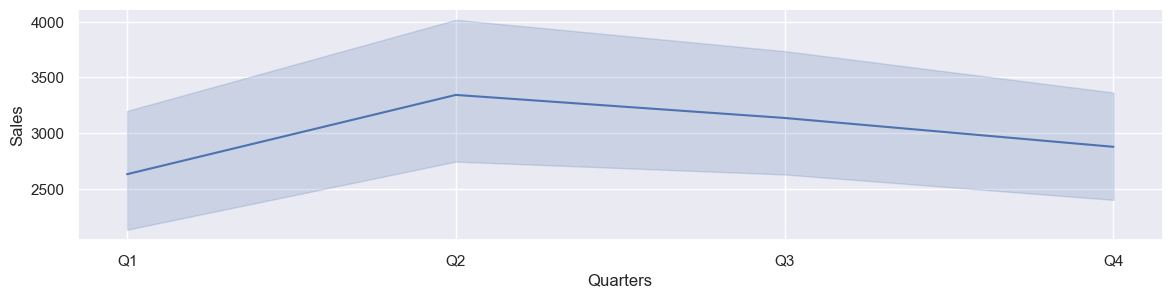

In [33]:
plt.figure(figsize=(14,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

<Axes: xlabel='Year', ylabel='Sales'>

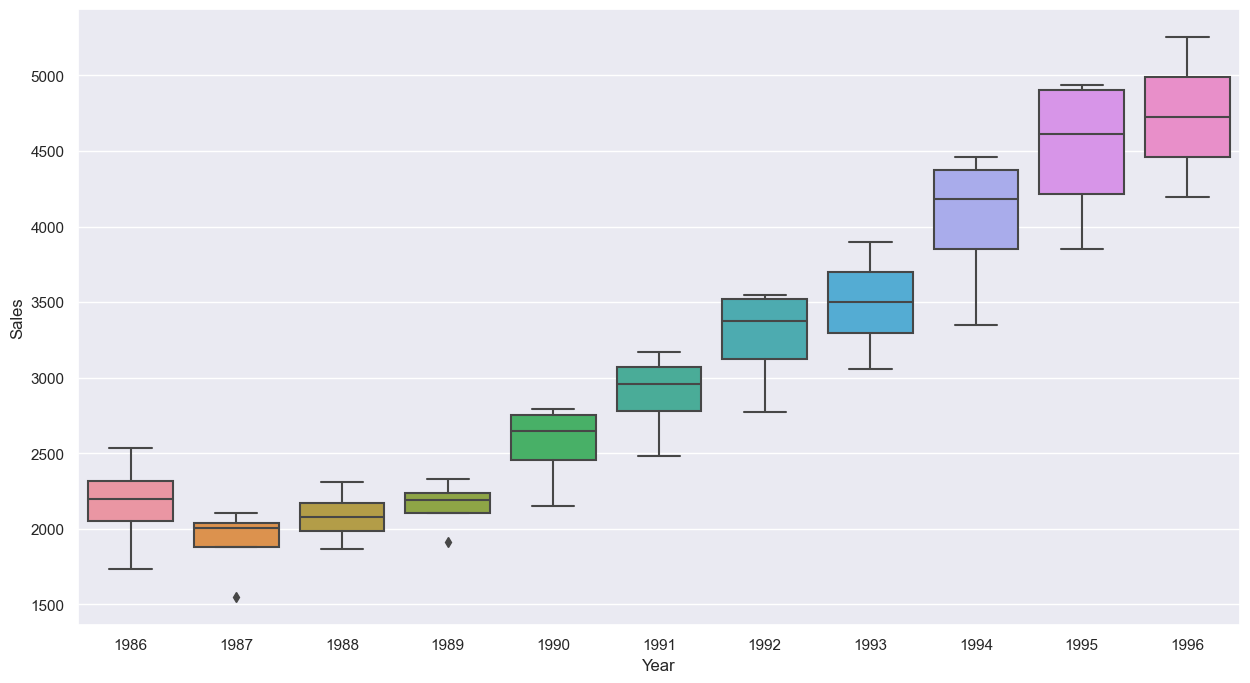

In [34]:
plt.figure(figsize=[15,8])
sns.boxplot(x="Year",y="Sales",data=df)

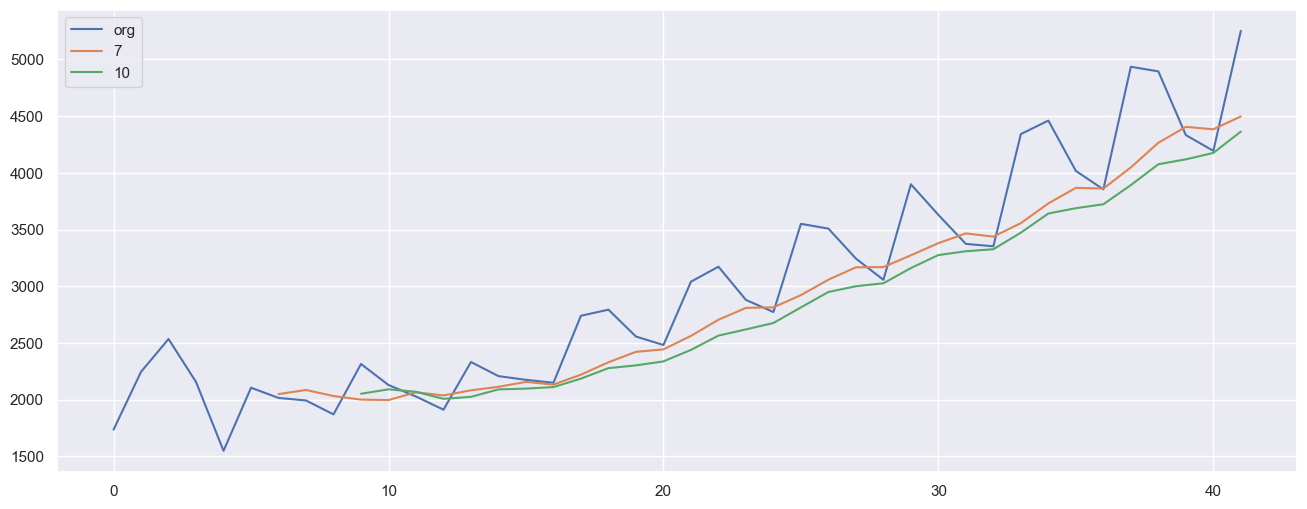

In [35]:
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(7,11,3):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Check the stationarity of the time series using the Augmented Dickey-Fuller (ADF) test.

In [77]:
result = sm.tsa.stattools.adfuller(sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 1.309421
p-value: 0.996661


The Augmented Dickey-Fuller (ADF) test is used to check for the presence of unit root in a time series dataset. The ADF statistic value of 1.309421 and p-value of 0.996661 suggest that the data is non-stationary and has a unit root. This implies that the data has a trend and is not stable over time. To build a time series model, the data needs to be transformed to make it stationary by removing the trend and seasonality components.

In [37]:

# First-order differencing
diff_sales = sales.diff(periods=1).dropna()


In [38]:

print("The values in this column are computed by subtracting the previous observation from the current observation in the original data. This is a common method for removing trend from a time series data.")
diff_sales

The values in this column are computed by subtracting the previous observation from the current observation in the original data. This is a common method for removing trend from a time series data.


Date
1986-04-01     510.133999
1986-07-01     288.843994
1986-10-01    -378.841995
1987-01-01    -607.144001
1987-04-01     556.592999
1987-07-01     -90.048996
1987-10-01     -22.616001
1988-01-01    -122.696999
1988-04-01     444.581997
1988-07-01    -185.311996
1988-10-01    -101.491001
1989-01-01    -116.225002
1989-04-01     420.560997
1989-07-01    -124.614998
1989-10-01     -32.582001
1990-01-01     -25.689995
1990-04-01     591.029999
1990-07-01      53.445999
1990-10-01    -236.744003
1991-01-01     -75.035995
1991-04-01     558.548996
1991-07-01     132.593002
1991-10-01    -293.114998
1992-01-01    -107.000999
1992-04-01     778.000000
1992-07-01     -42.000000
1992-10-01    -264.140007
1993-01-01    -187.859993
1993-04-01     843.000000
1993-07-01    -270.000000
1993-10-01    -256.000000
1994-01-01     -21.000000
1994-04-01     990.000000
1994-07-01     119.000000
1994-10-01    -444.000000
1995-01-01    -163.000000
1995-04-01    1082.000000
1995-07-01     -41.000000
1995-10

<Axes: xlabel='Date'>

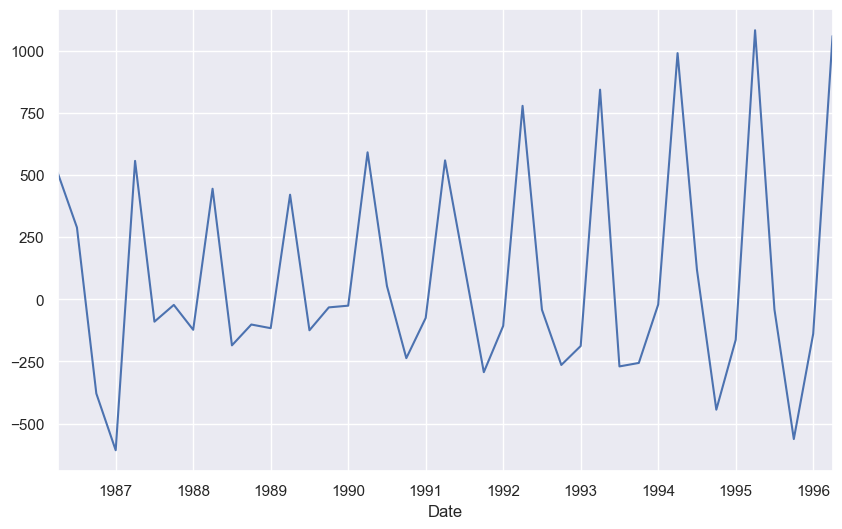

In [39]:
diff_sales.plot()

In [40]:
result = sm.tsa.stattools.adfuller(diff_sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.501537
p-value: 0.115101


the ADF statistic is negative, indicating that the series may be stationary after differencing. Further analysis may be needed to determine the appropriate order of differencing.




# Use PACF and ACF plots to determine the appropriate order of the AutoRegressive (AR) and Moving Average (MA)

 *partial autocorrelation function (PACF)
 *autocorrelation function (ACF)

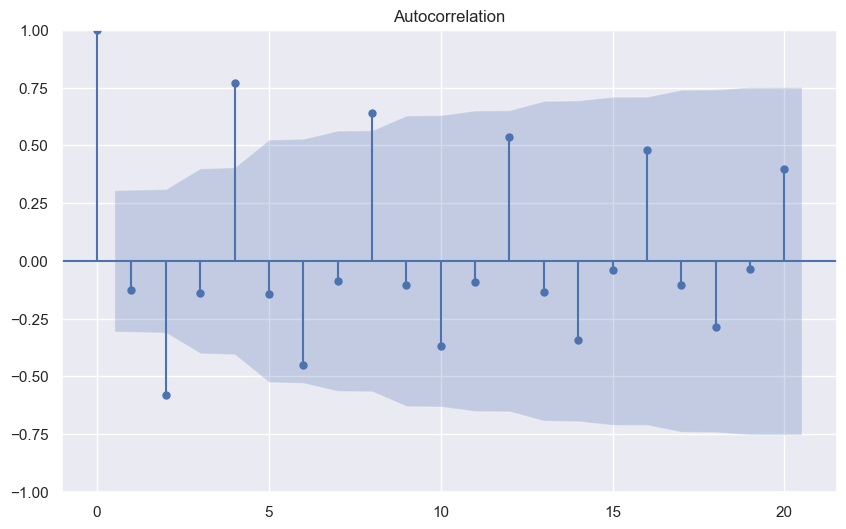

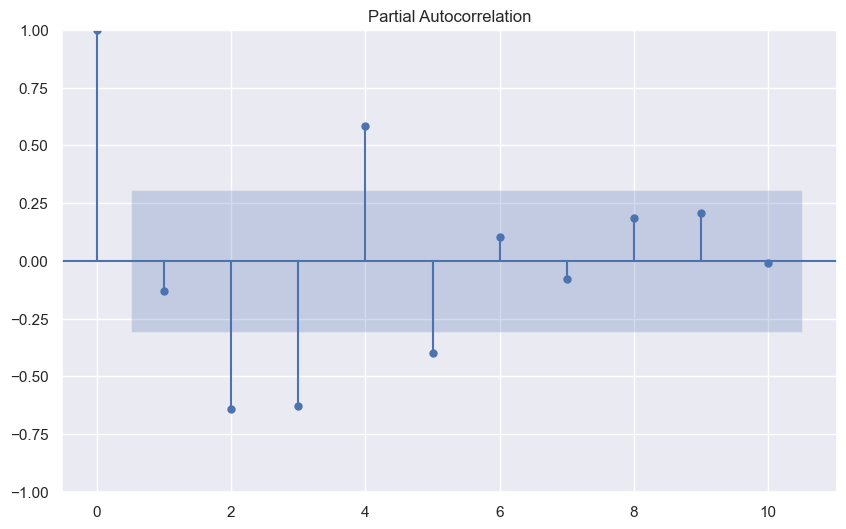

In [41]:
# plot ACF
plot_acf(diff_sales, lags=20)
plt.show()

# plot PACF
plot_pacf(diff_sales, lags=10)
plt.show()

# Evaluation Metric MAPE

In [42]:
def MAPE(pred, org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# simple exponential method

In [43]:
ses_model=SimpleExpSmoothing(sales).fit(smoothing_level=0.2)
pred_ses=ses_model.predict(start=sales.index[0],end=sales.index[-1])
MAPE(pred_ses,sales)

10.899242886501591

In [44]:
sales.index[0]

Timestamp('1986-01-01 00:00:00')

In [45]:
sales.index[-1]

Timestamp('1996-04-01 00:00:00')

In [46]:
x=np.linspace(0.1,1,20)
for i in x:
    ses_model = SimpleExpSmoothing(sales).fit(smoothing_level=i)
    pred_ses = ses_model.predict(start =sales.index[0],end = sales.index[-1])
    score=MAPE(pred_ses,sales)
    print("smoothing_level -- ",i,"-->", " MAPE Error ", score)

smoothing_level --  0.1 -->  MAPE Error  15.48767357321752
smoothing_level --  0.1473684210526316 -->  MAPE Error  12.77300885167958
smoothing_level --  0.19473684210526315 -->  MAPE Error  11.03910483858373
smoothing_level --  0.24210526315789474 -->  MAPE Error  10.10541526698564
smoothing_level --  0.2894736842105263 -->  MAPE Error  9.814785530022842
smoothing_level --  0.33684210526315794 -->  MAPE Error  9.688734349764658
smoothing_level --  0.38421052631578945 -->  MAPE Error  9.680049302462109
smoothing_level --  0.43157894736842106 -->  MAPE Error  9.831153608373771
smoothing_level --  0.4789473684210527 -->  MAPE Error  9.999408004846691
smoothing_level --  0.5263157894736842 -->  MAPE Error  10.147794859820614
smoothing_level --  0.5736842105263158 -->  MAPE Error  10.287233861451057
smoothing_level --  0.6210526315789474 -->  MAPE Error  10.389262295049495
smoothing_level --  0.6684210526315789 -->  MAPE Error  10.4794436562443
smoothing_level --  0.7157894736842105 -->  MA

1986-01-01    1734.827000
1986-04-01    1734.827000
1986-07-01    2244.960999
1986-10-01    2533.804993
1987-01-01    2154.962997
1987-04-01    1547.818996
1987-07-01    2104.411995
1987-10-01    2014.362999
1988-01-01    1991.746998
1988-04-01    1869.049999
1988-07-01    2313.631996
1988-10-01    2128.320000
1989-01-01    2026.828999
1989-04-01    1910.603996
1989-07-01    2331.164993
1989-10-01    2206.549995
1990-01-01    2173.967995
1990-04-01    2148.278000
1990-07-01    2739.307999
1990-10-01    2792.753998
1991-01-01    2556.009995
1991-04-01    2480.973999
1991-07-01    3039.522995
1991-10-01    3172.115997
1992-01-01    2879.000999
1992-04-01    2772.000000
1992-07-01    3550.000000
1992-10-01    3508.000000
1993-01-01    3243.859993
1993-04-01    3056.000000
1993-07-01    3899.000000
1993-10-01    3629.000000
1994-01-01    3373.000000
1994-04-01    3352.000000
1994-07-01    4342.000000
1994-10-01    4461.000000
1995-01-01    4017.000000
1995-04-01    3854.000000
1995-07-01  

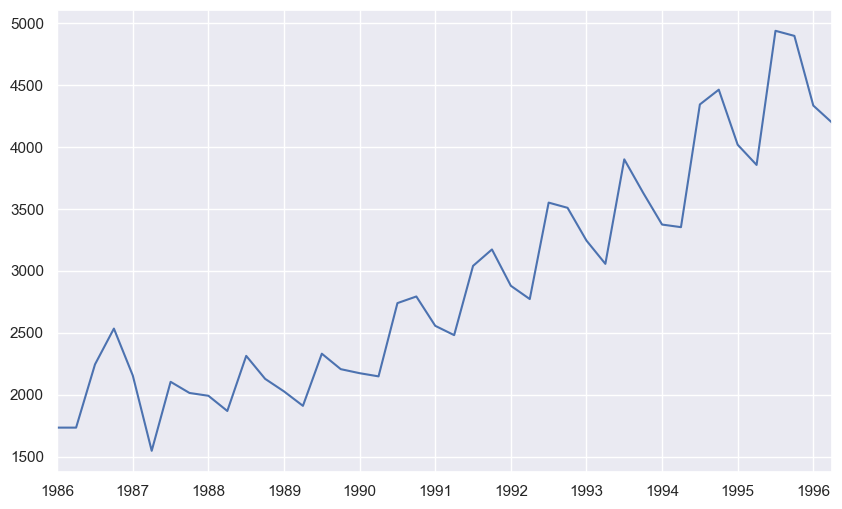

In [47]:
pred_ses.plot()
print(pred_ses)

# Holts  Winters method


In [48]:
hw_model= Holt(sales).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start=sales.index[0],end =sales.index[-1])
MAPE (pred_hw,sales)

11.935318476649563

1986-01-01    1855.402804
1986-04-01    1797.609135
1986-07-01    2265.733899
1986-10-01    2633.325422
1987-01-01    2327.232142
1987-04-01    1655.592182
1987-07-01    2038.349759
1987-10-01    2039.024196
1988-01-01    2013.501931
1988-04-01    1887.127570
1988-07-01    2285.759003
1988-10-01    2192.045452
1989-01-01    2065.675309
1989-04-01    1922.609868
1989-07-01    2295.814398
1989-10-01    2256.481001
1990-01-01    2209.346640
1990-04-01    2169.596790
1990-07-01    2725.624612
1990-10-01    2890.327677
1991-01-01    2680.382259
1991-04-01    2546.459057
1991-07-01    3045.403843
1991-10-01    3271.541147
1992-01-01    3019.470186
1992-04-01    2843.859965
1992-07-01    3544.120326
1992-10-01    3644.793146
1993-01-01    3389.466400
1993-04-01    3134.758432
1993-07-01    3880.495490
1993-10-01    3773.403623
1994-01-01    3483.120670
1994-04-01    3387.284772
1994-07-01    4312.872029
1994-10-01    4616.889956
1995-01-01    4226.511148
1995-04-01    3958.433603
1995-07-01  

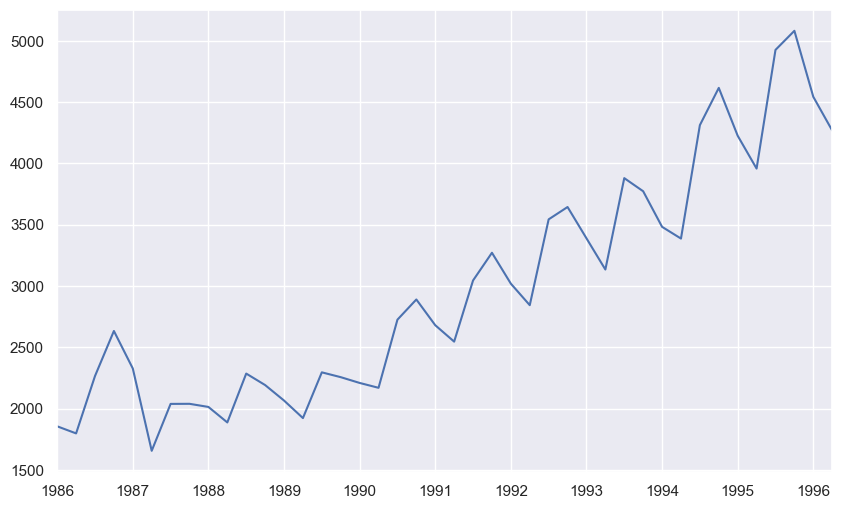

In [49]:
pred_hw.plot()
print(pred_hw)

In [50]:
alphas=np.arange (0.1,1,0.9/10)
betas=np.arange (0.1,1,0.9/10)
l=[]
for i in alphas :
    for j in betas:
        
        hw_model = Holt(sales).fit(smoothing_level=i, smoothing_slope=j)
        pred_hw = hw_model.predict(start = sales.index [0],end = sales.index [-1])
        score=MAPE(pred_hw,sales) 
        print("smoothing_level " ,i," smoothing_slope",j,"-->", "MAPE Error", score)
        l.append ( (i, j,score) )

smoothing_level  0.1  smoothing_slope 0.1 --> MAPE Error 10.378781822114256
smoothing_level  0.1  smoothing_slope 0.19 --> MAPE Error 9.496229671220073
smoothing_level  0.1  smoothing_slope 0.28 --> MAPE Error 9.440883197106093
smoothing_level  0.1  smoothing_slope 0.37 --> MAPE Error 9.517059448281115
smoothing_level  0.1  smoothing_slope 0.45999999999999996 --> MAPE Error 9.624843301752083
smoothing_level  0.1  smoothing_slope 0.55 --> MAPE Error 9.698951982828309
smoothing_level  0.1  smoothing_slope 0.64 --> MAPE Error 9.730444595100053
smoothing_level  0.1  smoothing_slope 0.73 --> MAPE Error 9.770425703049712
smoothing_level  0.1  smoothing_slope 0.82 --> MAPE Error 9.80047314954338
smoothing_level  0.1  smoothing_slope 0.9099999999999999 --> MAPE Error 9.827547961838786
smoothing_level  0.19  smoothing_slope 0.1 --> MAPE Error 9.631379516115333
smoothing_level  0.19  smoothing_slope 0.19 --> MAPE Error 9.58024755272606
smoothing_level  0.19  smoothing_slope 0.28 --> MAPE Error 9

In [51]:
a=pd.DataFrame(l, columns= ["alpha", "beta", "score"]) 
a.sort_values(["score"])

,alpha,beta,score
2,0.10,0.28,9.440883
1,0.10,0.19,9.496230
3,0.10,0.37,9.517059
11,0.19,0.19,9.580248
4,0.10,0.46,9.624843
...,...,...,...
69,0.64,0.91,14.659667
98,0.91,0.82,14.707556
79,0.73,0.91,14.892364
89,0.82,0.91,14.942467


# Holts winter exponential smoothing with additive seasonality and additive trend

In [52]:
hwe_model_add_add = ExponentialSmoothing(sales,seasonal="add", trend="add" ,seasonal_periods=4).fit() #a
pred_hwe_add_add = hwe_model_add_add.predict (start = sales. index [0], end = sales. index [-1])
MAPE (pred_hwe_add_add,sales)
#The resulting MAPE score can be used to evaluate the accuracy of the triple
#exponential smoothing model a.k.a holts winters method  with the specified parameters.

5.478253860130072

In [53]:
forecast_values=hwe_model_add_add.forecast(24)
hwe_model_add_add.forecast(24)

1996-07-01    5153.750821
1996-10-01    4693.189885
1997-01-01    4612.593531
1997-04-01    5629.561119
1997-07-01    5536.043315
1997-10-01    5075.482379
1998-01-01    4994.886025
1998-04-01    6011.853613
1998-07-01    5918.335809
1998-10-01    5457.774873
1999-01-01    5377.178519
1999-04-01    6394.146107
1999-07-01    6300.628303
1999-10-01    5840.067367
2000-01-01    5759.471013
2000-04-01    6776.438601
2000-07-01    6682.920797
2000-10-01    6222.359861
2001-01-01    6141.763507
2001-04-01    7158.731095
2001-07-01    7065.213291
2001-10-01    6604.652355
2002-01-01    6524.056001
2002-04-01    7541.023589
Freq: QS-OCT, dtype: float64

In [54]:
forecast_sales = pd.concat([sales, forecast_values])
forecast_sales = forecast_sales.cumsum()

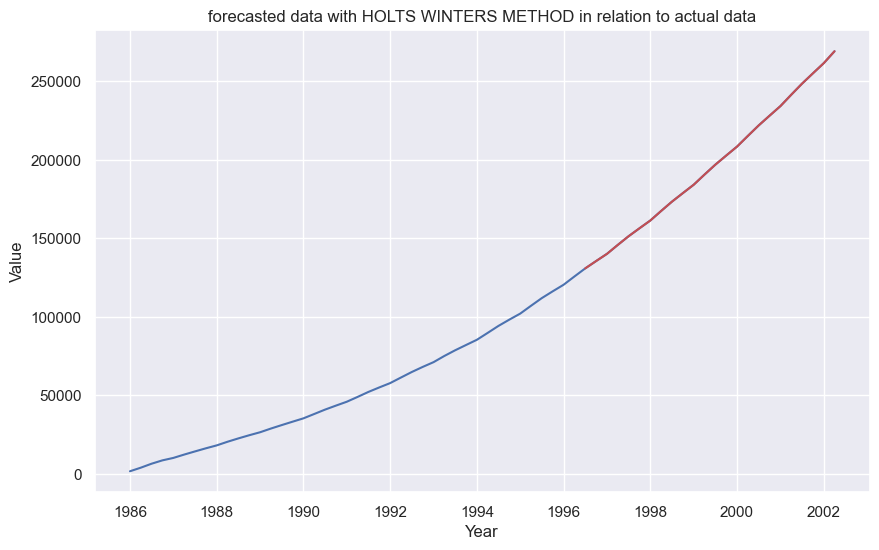

In [55]:
# create the line plot
sns.lineplot(data=forecast_sales, x=forecast_sales.index, y=forecast_sales.values)

# select the data to be in a different color
pred= forecast_sales.loc["1996-07-01":"2002-04-01"]
sns.lineplot(data=pred, x=pred.index, y=pred.values, color="r")

# set the title and labels
sns.set(rc={'figure.figsize':(10,6)})  # set the size of the plot
plt.title("forecasted data with HOLTS WINTERS METHOD in relation to actual data")
plt.xlabel("Year")
plt.ylabel("Value")
plt.show()  # show the plot

# Building Time series forecasting with ARIMA

In [56]:
X = diff_sales

In [57]:
size = int(len(X) * 0.66)

In [58]:
train, test = X[0:size], X[size:len(X)]

In [59]:
train

Date
1986-04-01    510.133999
1986-07-01    288.843994
1986-10-01   -378.841995
1987-01-01   -607.144001
1987-04-01    556.592999
1987-07-01    -90.048996
1987-10-01    -22.616001
1988-01-01   -122.696999
1988-04-01    444.581997
1988-07-01   -185.311996
1988-10-01   -101.491001
1989-01-01   -116.225002
1989-04-01    420.560997
1989-07-01   -124.614998
1989-10-01    -32.582001
1990-01-01    -25.689995
1990-04-01    591.029999
1990-07-01     53.445999
1990-10-01   -236.744003
1991-01-01    -75.035995
1991-04-01    558.548996
1991-07-01    132.593002
1991-10-01   -293.114998
1992-01-01   -107.000999
1992-04-01    778.000000
1992-07-01    -42.000000
1992-10-01   -264.140007
Name: Sales, dtype: float64

In [60]:
test

Date
1993-01-01    -187.859993
1993-04-01     843.000000
1993-07-01    -270.000000
1993-10-01    -256.000000
1994-01-01     -21.000000
1994-04-01     990.000000
1994-07-01     119.000000
1994-10-01    -444.000000
1995-01-01    -163.000000
1995-04-01    1082.000000
1995-07-01     -41.000000
1995-10-01    -562.000000
1996-01-01    -139.000000
1996-04-01    1059.000000
Name: Sales, dtype: float64

In [61]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   27
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -172.670
Date:                Wed, 05 Apr 2023   AIC                            357.340
Time:                        10:27:37   BIC                            364.889
Sample:                    04-01-1986   HQIC                           359.514
                         - 10-01-1992                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0297      0.229     -4.490      0.000      -1.479      -0.580
ar.L2         -1.3957      0.416     -3.356      0.001      -2.211      -0.581
ar.L3         -1.3067      0.428     -3.053      0.0

# Evaluate the model using statistical measures such as AIC, BIC and RMSE

In [62]:
# Fit the ARIMA model
model = ARIMA(diff_sales, order=(1, 1, 1))
model_fit = model.fit()

# Evaluate the model using AIC, BIC, and RMSE
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)
print("RMSE:", np.sqrt(np.mean(model_fit.resid**2)))


AIC: 608.4853583832644
BIC: 613.5519967456062
RMSE: 451.2882619616211


The AIC  and BIC values are measures of how well the model fits the data while penalizing for the number of parameters in the model. Lower values indicate better fit. The RMSE is a measure of the difference between the actual values and the predicted values. Smaller values indicate better accuracy. Therefore, based on the given values, the model appears to have a relatively good fit and accurate predictions.

In [63]:
#n is the number of quarters to be predicted
n=20
# Fit the ARIMA model
model = ARIMA(diff_sales, order=(1,1,1))
model_fit = model.fit()

# Forecast future values
forecast_values = model_fit.predict(start=len(diff_sales), end=len(diff_sales)+n-1, typ='levels')
# Print the forecasted values
print(forecast_values)

1996-07-01   -40.865461
1996-10-01    97.309174
1997-01-01    79.950479
1997-04-01    82.131229
1997-07-01    81.857264
1997-10-01    81.891682
1998-01-01    81.887358
1998-04-01    81.887901
1998-07-01    81.887833
1998-10-01    81.887841
1999-01-01    81.887840
1999-04-01    81.887840
1999-07-01    81.887840
1999-10-01    81.887840
2000-01-01    81.887840
2000-04-01    81.887840
2000-07-01    81.887840
2000-10-01    81.887840
2001-01-01    81.887840
2001-04-01    81.887840
Freq: QS-OCT, Name: predicted_mean, dtype: float64


                     .RESIDUAL PLOTS.  


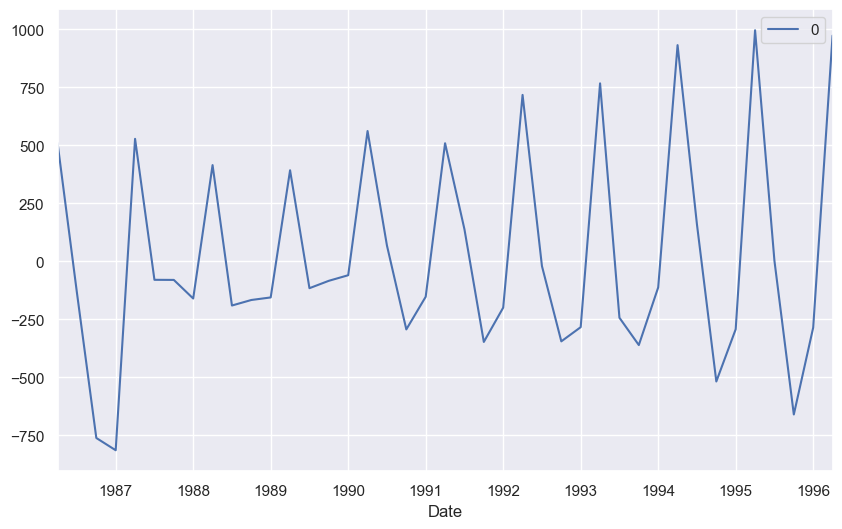

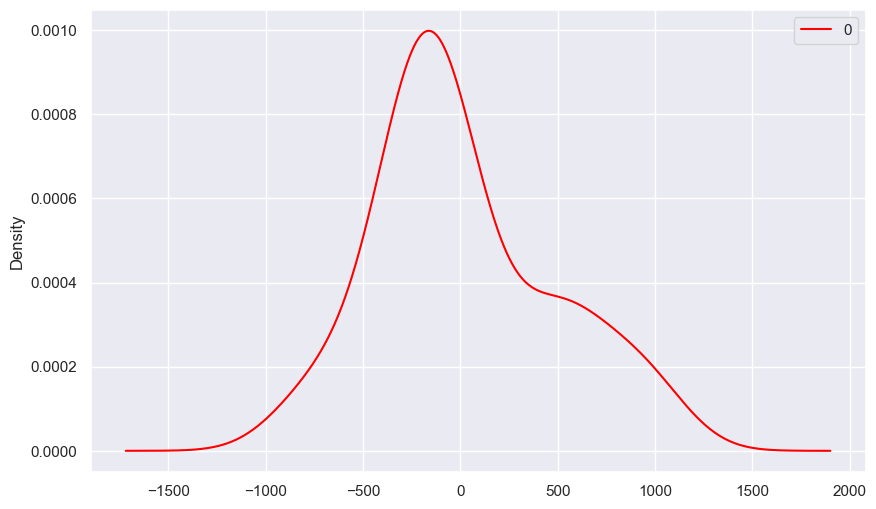

,0
count,41.000000
mean,18.622413
std,456.505376
min,-813.734971
25%,-283.335910
50%,-112.064524
75%,392.682717
max,996.072885


In [64]:
print("                     .RESIDUAL PLOTS.  ")
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde',color='red')
plt.show()
residuals.describe()

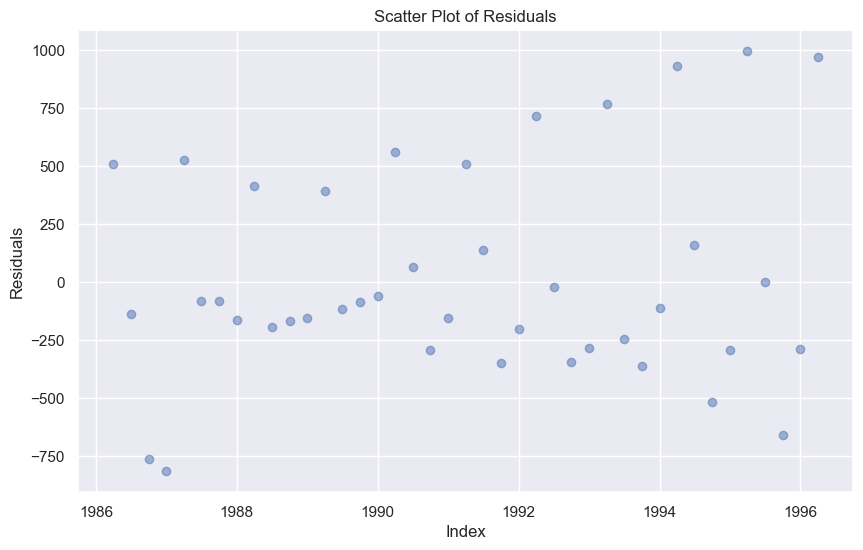

In [65]:
plt.scatter(residuals.index, residuals[0], alpha=0.5)
plt.title('Scatter Plot of Residuals')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

In [66]:
# Compute actual sales values
forecasted_sales = pd.concat([diff_sales, forecast_values])
forecasted_sales = forecasted_sales.cumsum()


mae = mean_absolute_error(df['Sales'][-n:], forecasted_sales[-n:])
mse = mean_squared_error(df['Sales'][-n:], forecasted_sales[-n:])
rmse = np.sqrt(mse)

print('MAE: {:.2f}'.format(mae))
print('MSE: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(rmse))


MAE: 484.04
MSE: 331071.76
RMSE: 575.39


In [67]:
forecasted_sales

1986-04-01     510.133999
1986-07-01     798.977993
1986-10-01     420.135998
1987-01-01    -187.008003
1987-04-01     369.584995
                 ...     
2000-04-01    4719.325343
2000-07-01    4801.213184
2000-10-01    4883.101024
2001-01-01    4964.988865
2001-04-01    5046.876705
Length: 61, dtype: float64

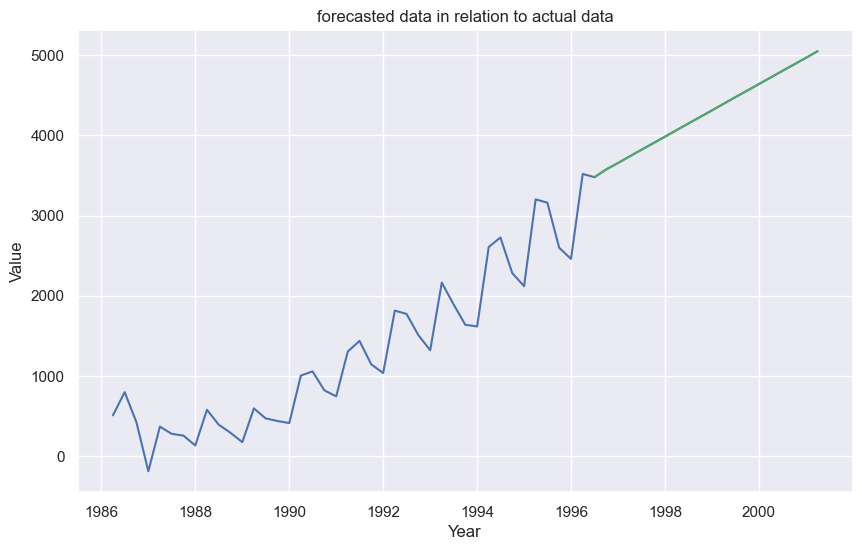

In [68]:
# create the line plot
sns.lineplot(data=forecasted_sales, x=forecasted_sales.index, y=forecasted_sales.values)

# select the data to be in a different color
pred= forecasted_sales.loc["1996-07-01":"2001-04-01"]
sns.lineplot(data=pred, x=pred.index, y=pred.values, color="g")

# set the title and labels
sns.set(rc={'figure.figsize':(10,6)})  # set the size of the plot
plt.title("forecasted data in relation to actual data")
plt.xlabel("Year")
plt.ylabel("Value")
plt.show()  # show the plot


# MOVING AVERAGE OF FORCASTED DATA

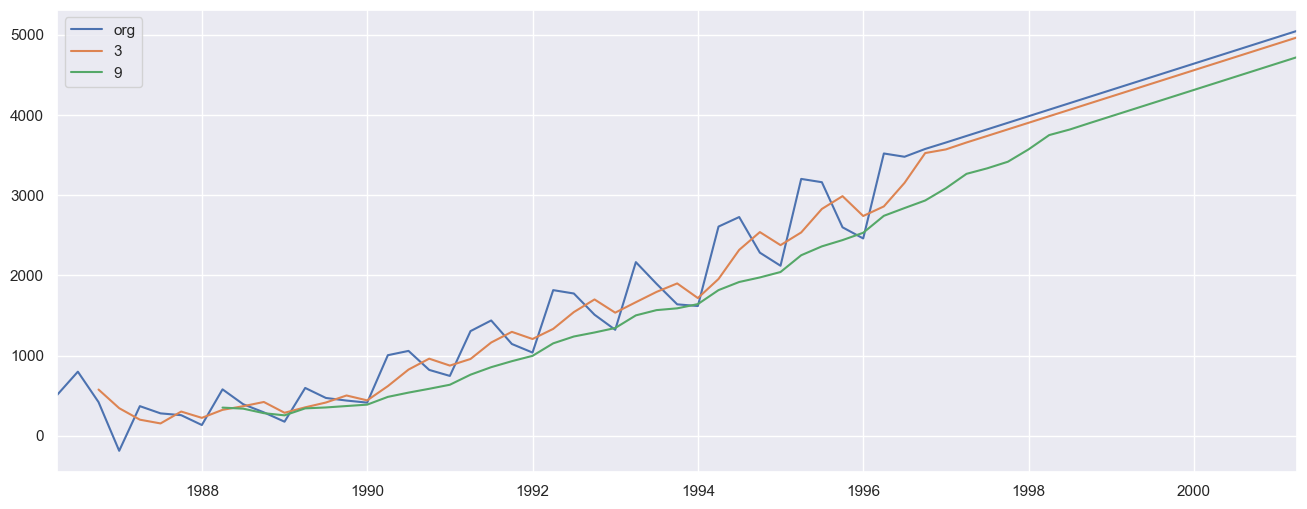

In [69]:
plt.figure(figsize=(16,6))
forecasted_sales.plot(label="org")
for i in range(3,10,6):
    forecasted_sales.rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

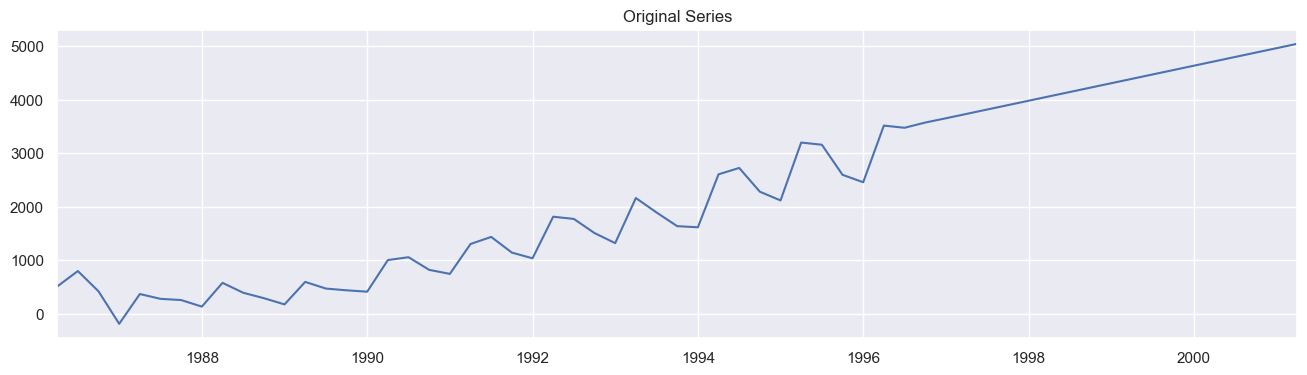

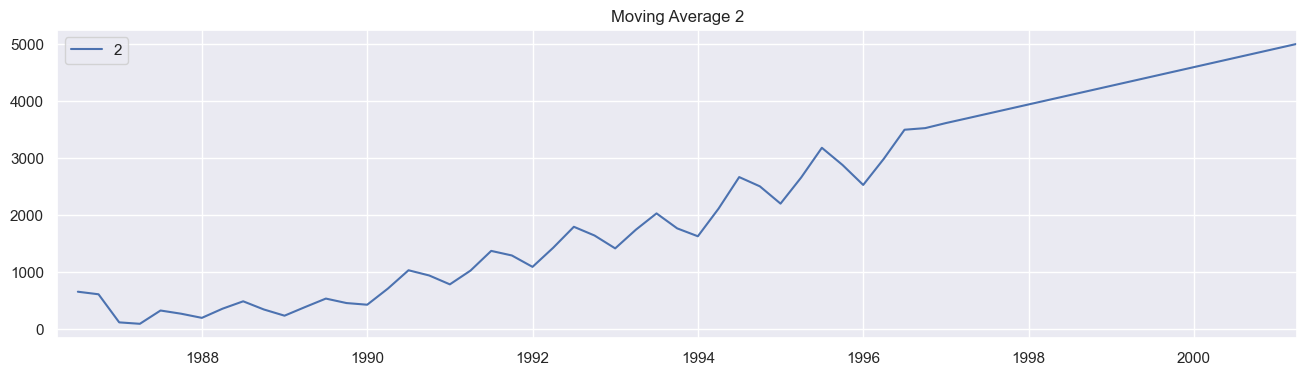

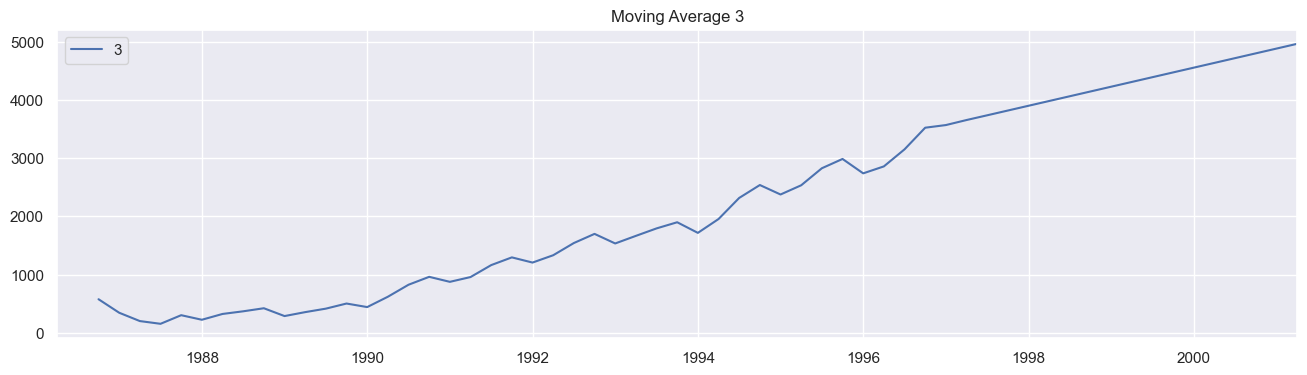

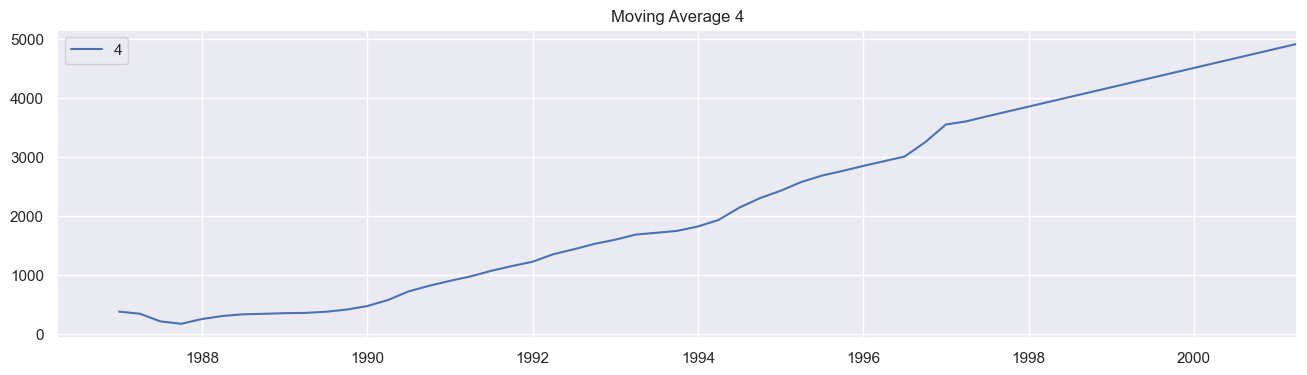

In [70]:
plt.figure(figsize=(16,4))
forecasted_sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    forecasted_sales.rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

# TIME SERIES DECOMPOSITION PLOT OF FORECASTED DATA

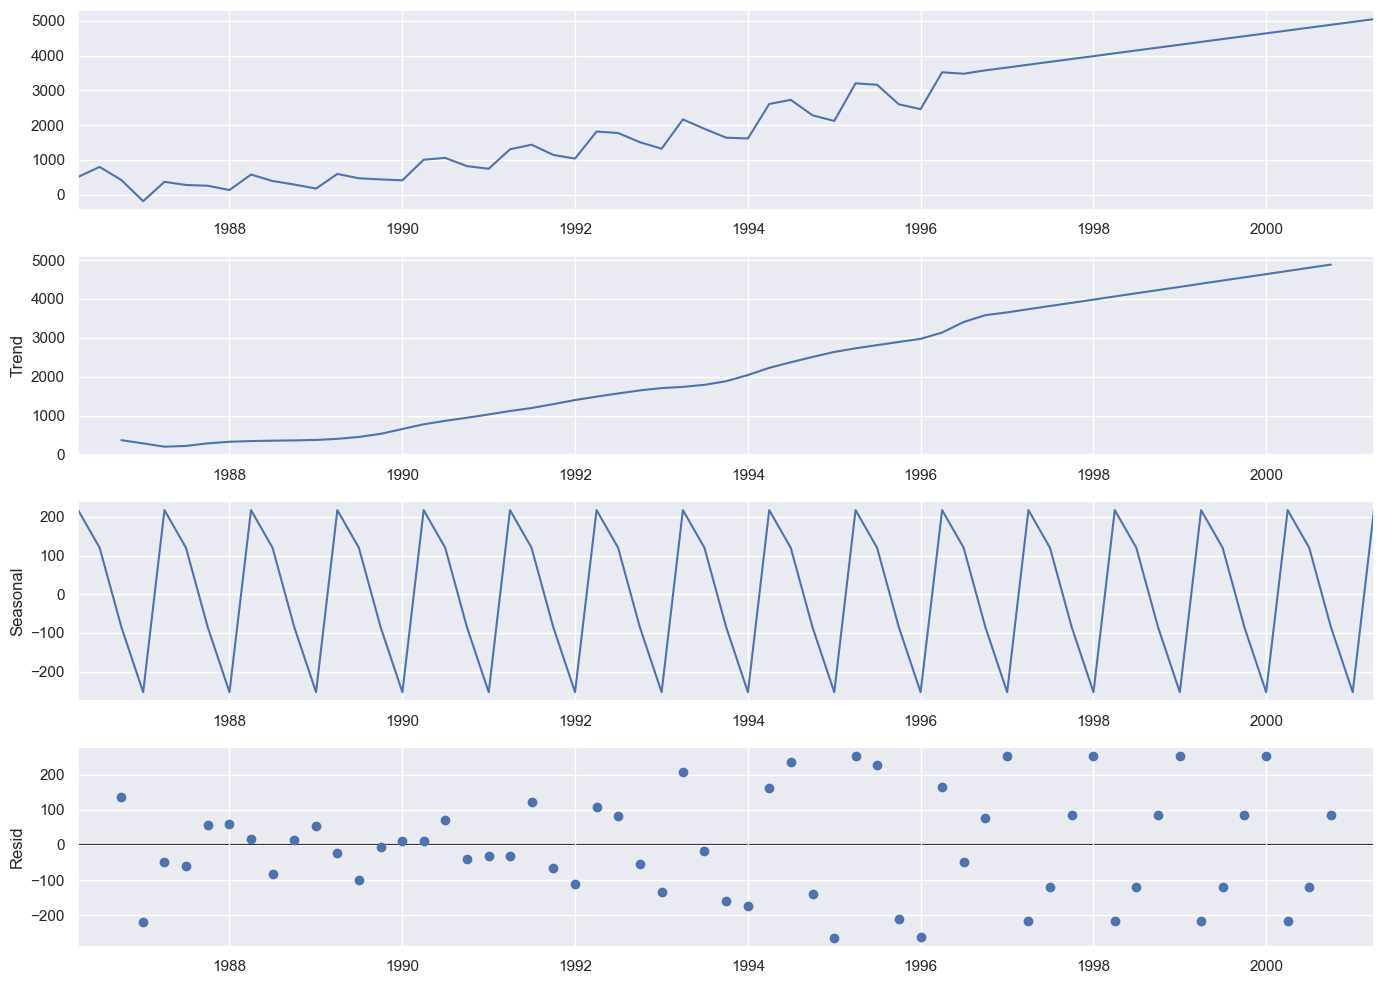

In [71]:
decompose_ts_add = seasonal_decompose(forecasted_sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()